# Stack observation images

In this notebook we will search for a given observation and then make some simple image stacks of the data.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import requests
from tqdm.auto import tqdm
from astropy.visualization import simple_norm
from astropy.coordinates import SkyCoord

from helpers import ObservationInfo, search_observations

## Search for observations

Using a sky coordinate, search for all matching observations with a certain radius.

In [2]:
# search_coords = SkyCoord('18h 08m 30s +08d00m00s')  # Comet C/2017 PANSTARRS
search_coords = SkyCoord.from_name('M42')

search_coords

<SkyCoord (ICRS): (ra, dec) in deg
    (83.82208, -5.39111)>

In [3]:
search_results = search_observations(
    coords=search_coords,
    radius=10,
    unit_id='PAN019'
)

2022-06-22 03:28:24.463 | DEBUG    | helpers:search_observations:326 - Setting up search params
2022-06-22 03:28:24.466 | DEBUG    | helpers:search_observations:351 - Getting list of observations
2022-06-22 03:28:24.548 | INFO     | helpers:search_observations:362 - Found 6547 total observations
2022-06-22 03:28:24.548 | DEBUG    | helpers:search_observations:365 - Filtering observations
2022-06-22 03:28:24.557 | DEBUG    | helpers:search_observations:379 - Found 185 observations after initial filter
2022-06-22 03:28:24.561 | DEBUG    | helpers:search_observations:384 - Found 20 observations after unit filter
2022-06-22 03:28:24.564 | DEBUG    | helpers:search_observations:388 - Found 19 observations after status filter
2022-06-22 03:28:24.565 | DEBUG    | helpers:search_observations:390 - Found 19 observations after filtering
2022-06-22 03:28:24.572 | SUCCESS  | helpers:search_observations:405 - Returning 19 observations


## Select observation

A `sequence_id` is used to explore observations. Here we get the most observation to get the `sequence_id`.

In [16]:
# We choose an entry that only has a few images while running on binder and get the most recent.

# record = search_results.iloc[-1]  # The most recent observation.
record = search_results.query('num_images < 15').iloc[-1]  # The most recent observation with limited images.
record.T

camera_id                                                   c623e9
camera_lens_serial_number                                RL1552832
camera_serial_number                                  273074013304
coordinates_mount_dec                                     -5.39111
coordinates_mount_ra                                      83.82208
exptime                                                       89.0
field_name                                                     M42
num_images                                                    12.0
sequence_id                          PAN019_c623e9_20220117T104417
software_version             POCSv0.8.0.post0.dev7+g8c57c125.dirty
status                                                     CREATED
time                                     2022-01-17 10:44:17+00:00
total_exptime                                               1068.0
unit_id                                                     PAN019
Name: 830, dtype: object

In [17]:
sequence_id = record.sequence_id
sequence_id

'PAN019_c623e9_20220117T104417'

## Get Observation info

We can get more information about the observation by creating an `ObservationInfo` object. You can create it with just a `sequence_id` (e.g. `ObservationInfo(sequence_id=record.sequence_id)) but here we pass all the meta data.

In [18]:
obs_info = ObservationInfo(sequence_id)

Found 12 images in observation


## Plot a single image

We can retrieve the data for the image by using the `get_image_data` function using the index of the image from the `raw_images` list.

An optional `coords` and `box_size` allow for cropping of the data as it is returned (the full data still travels over the network as of now).

You can also retrieve the raw or processed data using the `use_raw=True` flag.

In [19]:
cutout_size = (250, 250)

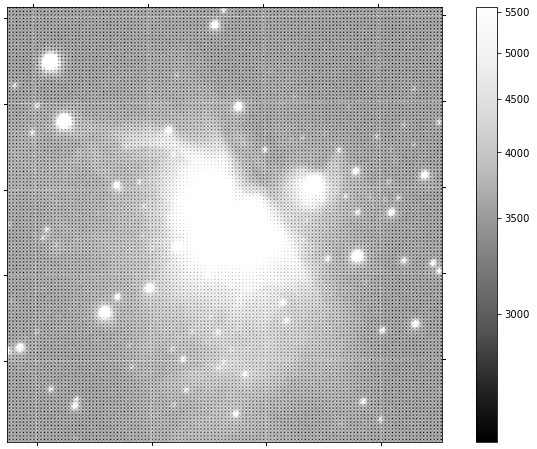

In [ ]:
data0 = obs_info.get_image_data(use_raw=True)
cutout0 = obs_info.get_image_cutout(data=data0, coords=search_coords, box_size=cutout_size)

ax = plt.subplot(projection=cutout0.wcs)

norm = simple_norm(cutout0.data, 'sqrt', min_percent=5, max_percent=94)

im = ax.imshow(cutout0.data, origin='lower', norm=norm, cmap='Greys_r')
ax.figure.colorbar(im)
ax.figure.set_size_inches(12, 8)

plt.grid(color='white', ls='--', alpha=0.5);

In [ ]:
# Plot on the original.
ax = plt.subplot(projection=data0.wcs)

norm = simple_norm(data0.data, 'asinh', min_percent=10, max_percent=99.9)
ax.imshow(data0.data, origin='lower', norm=norm, cmap='Greys_r')
cutout0.plot_on_original(color='white')

ax.grid(color='white', ls='dotted')

ax.figure.set_size_inches(16, 12)

We can perform this action in a loop to retrieve the same cutout for all the images in the observation.

Below we fetch the data for all the images into a list and then plot a single frame (similar to above), a median stack, and summation of all the data.

### Stack images

Here we grab cutoutouts centered around our `search_coords` for all the images in this observation.

In [21]:
stack_cutout = list()
for i, img in tqdm(enumerate(obs_info.raw_images), total=len(obs_info.raw_images), desc='Fetching image cutouts'):
    try:
        cutout_data = obs_info.get_image_cutout(idx=i, coords=search_coords, box_size=cutout_size).data
        stack_cutout.append(cutout_data)
    except Exception:
        # Skip some that have errors.
        pass
                        
stack_cutout = np.array(stack_cutout)

Fetching image cutouts:   0%|          | 0/12 [00:00<?, ?it/s]

We then make some simple plots of the data in various ways: a single frame, the difference image for the observation, a median stack, and a full co-add.

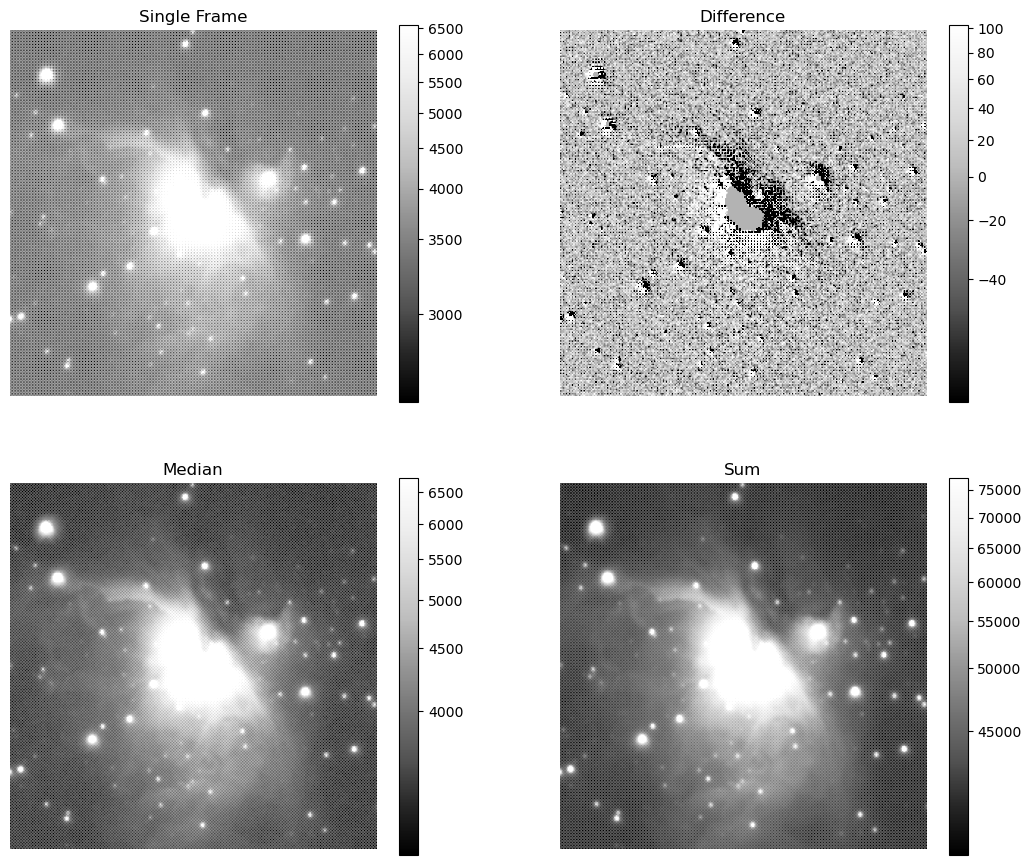

In [24]:
stretch = 'sqrt'

fig, axes = plt.subplots(ncols=2, nrows=2)

# Make a difference image.
diffs = pd.DataFrame(stack_cutout.reshape(stack_cutout.shape[0], -1).astype('float'))
diffs = diffs.diff().values.reshape(stack_cutout.shape[0], *cutout_size)[1:]

# Show different types of plots.
types = {
    'Single Frame': stack_cutout[0],
    'Difference': np.median(diffs, 0),
    'Median': np.median(stack_cutout, 0),
    'Sum': stack_cutout.sum(0),
}

# Create each plot type.
for i, (title, data) in enumerate(types.items()):
    ax = axes.flatten()[i]
    im = ax.imshow(data, norm=simple_norm(data, stretch, min_percent=10, max_percent=96), origin='lower', cmap='Greys_r')
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.axis('off')

fig.set_dpi(100)
fig.set_size_inches(13, 11)